In [1]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [6]:
from pennylane import numpy as np
import matplotlib.pyplot as plt

def generate_points_distribution(data_num=2000, dist_type="circle"):
    if dist_type == 'spiral':
        theta = np.linspace(0, 5*np.pi, data_num)  # 각도 범위를 정의합니다.
        radius = np.linspace(0, 0.3, data_num)  # 반지름 범위를 정의합니다.
        xx = 0.5 + radius * np.cos(theta) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = 0.5 + radius * np.sin(theta) + 0.012 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'box':
        xx = np.random.uniform(0.3, 0.7, data_num) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = np.random.uniform(0.3, 0.7, data_num) + 0.012 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'curve':
        xx = np.linspace(0.15, 0.85, data_num) + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = 3.8 * xx*xx - 3.8 * xx + 1.2 + 0.03 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'circle':
        radius = 0.05
        theta = np.linspace(0, 2 * np.pi, data_num)  # 각도 범위를 정의합니다.
        xx = radius * np.cos(theta) + 0.3 + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = radius * np.sin(theta) + 0.3 + 0.02 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'lemniscate':
        xx = []
        yy = []
        while len(xx) < data_num:
            x = np.random.uniform(0, 0.5)
            y = np.random.uniform(0, 0.5)
            
            r = (x**2 + y**2)**0.5
            theta = np.arctan2(y, x)
            if r**2 <= 2 * 0.25**2 * np.cos(2 * theta):
                x = x if np.random.uniform(0, 1) < 0.5 else -x
                y = y if np.random.uniform(0, 1) < 0.5 else -y
                xx.append(x+0.5)
                yy.append(y+0.5)

    data = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
    np.random.shuffle(data)
    
    return data

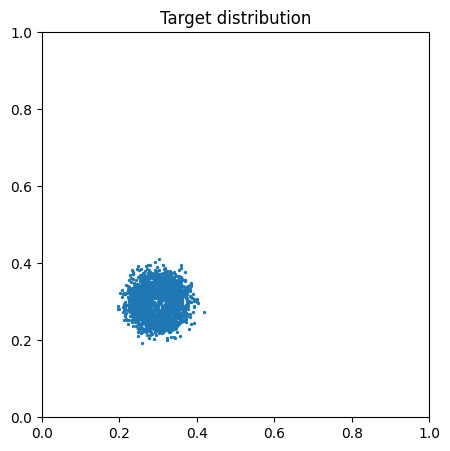

In [8]:
x = generate_points_distribution(2000, 'circle')
plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.title('Target distribution')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [9]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
noise_qubits = 3
code_qubits = 2
n_qubits = noise_qubits + code_qubits
output_qubits = 2
assert(output_qubits <= noise_qubits) # 출력 큐빗은 noise qubit이하여야 한다.

n_layers = 5
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("ionq.simulator", wires=2)
# dev = qml.device("ionq.qpu", wires=2)

n_qubits = 5 n_layers = 5


In [17]:
coeff = 0.1

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit nodeq1
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return [qml.probs(wires=i) for i in range(n_qubits)]

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in)[::2] for single_in in generator_input]
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, n_qubits) 차원
    #generator_output = 2 * (2 / np.pi * torch.arcsin(torch.sqrt(generator_output))) -0.5 # (BATCH_SIZE, n_qubits) 차원
    # 곱하기 2 해서 범위를 초과하게 만들음

    return generator_output[:, :output_qubits], generator_output[:, -code_qubits:] # noise, code 순서로 반환


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    '''
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    generator_input (torch.Tensor(BATCH_SIZE, n_qubits)): 생성기 입력 seed (noise + code). -1~1 사이의 값
    '''
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = -torch.log(disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return generator_output, gan_loss# TODO: 이건 분석용으로 넣어놓음.지워야 함.


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [18]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=output_qubits):
        super().__init__()
        self.hidden_size = 50
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 50
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [19]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()
mine = LinearMine()

parameter shape:  torch.Size([5, 5, 3])


In [20]:
G_lr = 1e-3
D_lr = 1e-4
M_lr = 3e-3

use_mine = False
use_qmine = False
G_opt = torch.optim.Adam([generator_params], lr=G_lr)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

G_scheduler = torch.optim.lr_scheduler.StepLR(G_opt, step_size=30, gamma=0.7)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.85)
M_scheduler = torch.optim.lr_scheduler.StepLR(M_opt, step_size=30, gamma=0.7)

### 하이퍼파라미터 미리 저장

In [21]:
import os
title = f'bc_nf_{use_mine}'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')
    
with open(f'result/{title}/param.txt', 'w') as f:
    f.write('G_lr = {}\n'.format(G_lr))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('G_scheduler: step={}, gamma={}\n'.format(G_scheduler.step_size, G_scheduler.gamma))
    f.write('D_scheduler: step={}, gamma={}\n'.format(D_scheduler.step_size, D_scheduler.gamma))
    f.write('M_scheduler: step={}, gamma={}\n'.format(M_scheduler.step_size, M_scheduler.gamma))
    f.write('coeff = {}\n'.format(coeff))
    f.write('use_mine = {}\n'.format(use_mine))
    f.write('use_qmine = {}\n'.format(use_qmine))
    f.write('n_qubits = {}\n'.format(n_qubits))
    f.write('output_qubits = {}\n'.format(output_qubits))
    f.write('code_qubits = {}\n'.format(code_qubits))
    f.write('n_layers = {}\n'.format(n_layers))
    f.write('param shape = {}\n'.format(generator_params.shape))

In [22]:
import warnings

def visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder):
    warnings.simplefilter("ignore")
    plt.figure(figsize=(10 + 4 * code_qubits, 4))  # 전체 그림의 크기 지정
    plt.subplot(1, 1 + code_qubits, 1)
    plt.title('Epoch {0}'.format(rep))
    plt.scatter(log_gen_outputs[:,0], log_gen_outputs[:,1], s=10,  alpha=0.2)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()

    for i in range(code_qubits):
        plt.subplot(1, 1 + code_qubits, 2 + i)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(log_gen_outputs[:,0], log_gen_outputs[:,1], s=10, c=log_gen_codes[:, i], cmap='RdYlBu', alpha=0.2)
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.colorbar()  # 색상 막대 추가
        plt.grid()

    plt.savefig(f'result/{title}/{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()
    
    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} code-axis corr'.format(rep))
    plt.plot(recorder['d_loss'], label='d_loss', marker='o')
    plt.plot(recorder['g_loss'], label='g_loss', marker='o')
    plt.plot(recorder['mi'], label='mi', marker='o')
    for i in range(code_qubits):
        plt.plot(recorder[f'code{i}-x'], label=f'code{i}-x', marker='o')
        plt.plot(recorder[f'code{i}-y'], label=f'code{i}-y', marker='o')

    plt.xlabel('epoch')
    plt.ylabel('correlation')
    plt.ylim(-1, 1)
    plt.title(f'trainning graph (rep={rep})')
    plt.legend()
    plt.savefig(f'result/{title}/corr_{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()

    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} KS stastics'.format(rep))
    plt.subplot(1, 2, 1)
    plt.plot(recorder['D_ks'], label='D_ks', marker='o')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(recorder['p-value'], label='p-value', marker='o')
    plt.yscale("log", base=10)  # 로그 스케일로 설정
    plt.legend()
    plt.savefig(f'result/{title}/ks_{rep}.png', dpi=100)
    if rep % 5 == 0:
        plt.show()
    plt.clf()
    plt.close()
    

100%|██████████| 31/31 [00:15<00:00,  1.96it/s, G_loss=0.704, D_loss=0.691, MI=0.00358]


epoch: 1, D_loss: 0.6909660562392204, G_loss: 0.7043185368660958, MI = 0.003577150164111968
좌표값 평균 =  0.41206482 0.50348246
D_ks = 0.9539193548387097, p-value = 3.813528178984365e-214


100%|██████████| 31/31 [00:15<00:00,  1.99it/s, G_loss=0.716, D_loss=0.688, MI=0.00895]


epoch: 2, D_loss: 0.6875584779247161, G_loss: 0.7163308320506927, MI = 0.008952414797198388
좌표값 평균 =  0.38756487 0.4851529
D_ks = 0.9264112903225807, p-value = 4.0169430631964067e-202


100%|██████████| 31/31 [00:15<00:00,  1.99it/s, G_loss=0.718, D_loss=0.686, MI=0.0118] 


epoch: 3, D_loss: 0.6858755580840572, G_loss: 0.7181415038724099, MI = 0.011838533224598054
좌표값 평균 =  0.37983623 0.4450455
D_ks = 0.8220887096774194, p-value = 2.3422818153308304e-159


100%|██████████| 31/31 [00:15<00:00,  2.00it/s, G_loss=0.721, D_loss=0.684, MI=0.0165]


epoch: 4, D_loss: 0.6843894316304114, G_loss: 0.7205730407468734, MI = 0.016501640119860248
좌표값 평균 =  0.37256905 0.42122105
D_ks = 0.7717338709677419, p-value = 1.3587441600880518e-140


100%|██████████| 31/31 [00:15<00:00,  2.01it/s, G_loss=0.719, D_loss=0.684, MI=0.0248]


epoch: 5, D_loss: 0.6837406600675275, G_loss: 0.7187407209027198, MI = 0.024751647826164
좌표값 평균 =  0.35556057 0.40259457
D_ks = 0.69025, p-value = 6.227822933937125e-113


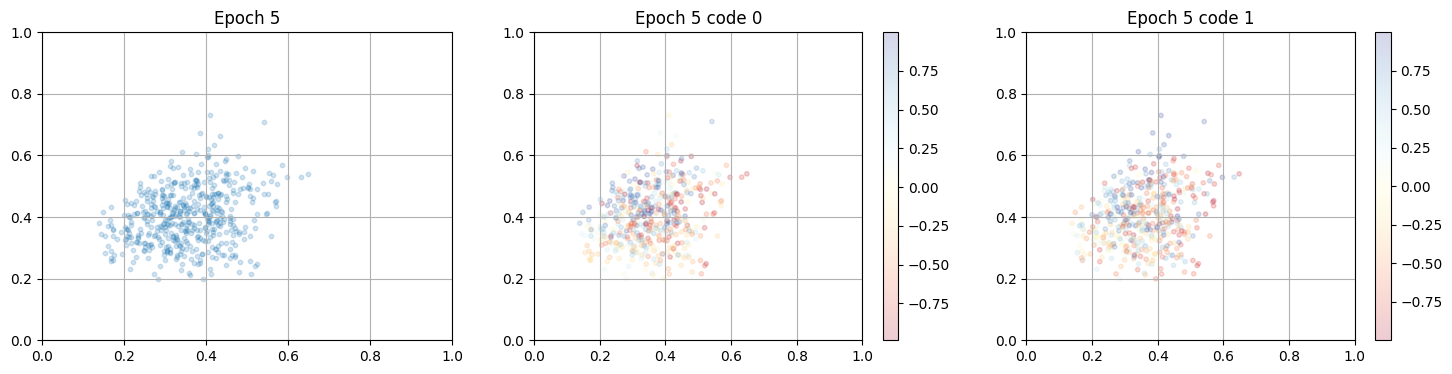

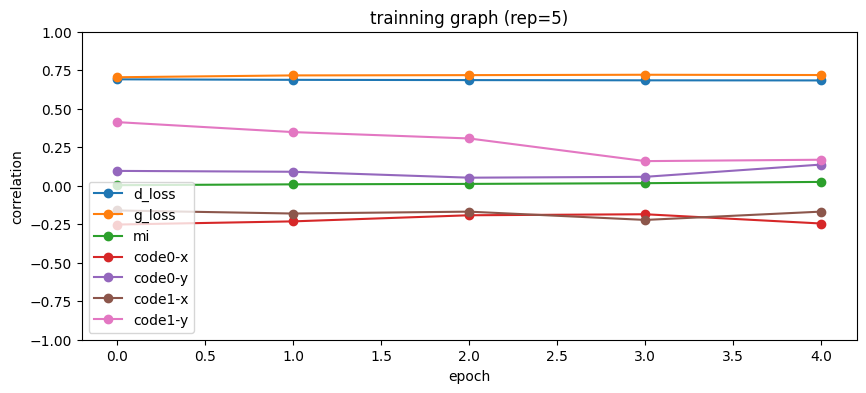

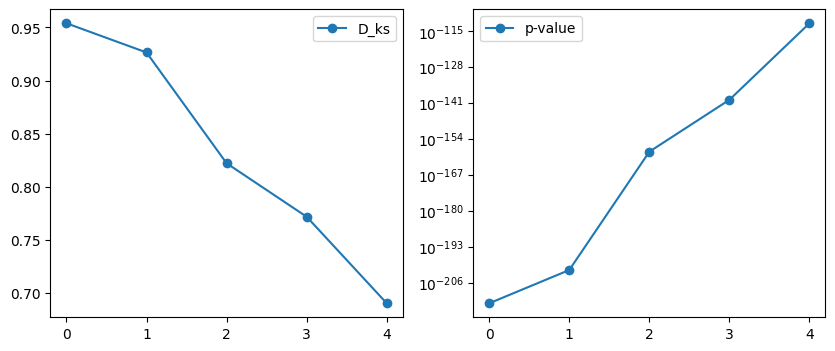

 35%|███▌      | 11/31 [00:06<00:10,  1.83it/s, G_loss=0.716, D_loss=0.684, MI=0.0242]


KeyboardInterrupt: 

In [23]:
import ndtest
import openpyxl
epoch = 300

recorder_keywords = ['d_loss', 'g_loss', 'mi', 'D_ks', 'p-value']
for i in range(code_qubits):
    recorder_keywords.append(f'code{i}-x')
    recorder_keywords.append(f'code{i}-y')

recorder = {k: [] for k in recorder_keywords}
final_rep = 0

for rep in range(1, epoch+1):
    np.random.shuffle(x)
    iter_num = int(len(x)*0.25//BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    
    G_loss_sum = 0.0
    D_loss_sum = 0.0
    mi_sum = 0.0
    pbar = tqdm(range(iter_num))
    log_gen_outputs = []
    log_gen_codes = []
    
    for i in pbar:
        batch = torch.FloatTensor(x[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])
        
        # train generator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1
        generator_output, generator_loss = generator_train_step(generator_params, generator_seed, use_mine=use_mine, _qmine=use_qmine)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()

        # train discriminator
        fake_input = generator_output.detach().to(torch.float32)
        disc_loss = disc_cost_fn(batch, fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()

        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    G_scheduler.step()
    D_scheduler.step()
    M_scheduler.step()

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss_sum/iter_num)
    recorder['mi'].append(mi_sum/iter_num)
    
    log_gen_outputs = np.concatenate(log_gen_outputs, axis=0)
    log_gen_codes = np.concatenate(log_gen_codes, axis=0)
    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num, mi_sum/iter_num))
    print("좌표값 평균 = ", np.mean(log_gen_outputs[:,0]), np.mean(log_gen_outputs[:,1]))

    df = pd.DataFrame({'x': log_gen_outputs[:, 0], 'y': log_gen_outputs[:, 1]})
    for i in range(code_qubits):
        df[f'code{i}']=log_gen_codes[:, i]
    corr_mat = df.corr().to_numpy()
    for i in range(code_qubits):
        recorder[f'code{i}-x'].append(corr_mat[0, i+2])
        recorder[f'code{i}-y'].append(corr_mat[1, i+2])
    
    p_value, D_ks = ndtest.ks2d2s(log_gen_outputs[:, 0], log_gen_outputs[:, 1], x[:, 0], x[:, 1], extra=True)
    recorder['D_ks'].append(D_ks)
    recorder['p-value'].append(p_value)
    print("D_ks = {}, p-value = {}".format(D_ks, p_value))

    visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder)

    with open(f'result/{title}/Opts_{rep}.pkl', 'wb') as file:
        pickle.dump((G_opt, D_opt, M_opt), file)
    with open(f'result/{title}/schedulers_{rep}.pkl', 'wb') as file:
        pickle.dump((G_scheduler, D_scheduler, M_scheduler), file)
    with open(f'result/{title}/generator_{rep}.pkl', 'wb') as file:
        pickle.dump(generator_params, file)


    df = pd.DataFrame(recorder)
    output_filename = f'result/{title}/recorder.xlsx'
    df.to_excel(output_filename, index=False)

    final_rep = rep

## Target distribution 저장

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.title('Target distribution')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.savefig(f'result/{title}/target.png', dpi=300)
plt.show()

## Target distribution 저장

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.title('Target distribution')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.savefig(f'result/{title}/target.png', dpi=300)
plt.show()

# 모델 불러오는 코드

In [ ]:
import pickle

with open(f'result/{title}/discriminator2.pkl', 'rb') as file:
    discriminator = pickle.load(file)

with open(f'result/{title}/generator.pkl', 'rb') as file:
    generator_params = pickle.load(file)